In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = "cotton-plant-disease-data"

In [3]:
# extra code to save the figures as high-res PNGs for the book
from pathlib import Path

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

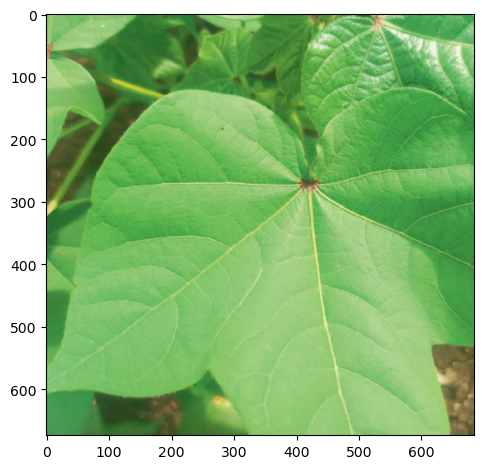

In [4]:
import matplotlib.image as mping
test_image = "cotton-plant-disease-data/Healthy leaf/1.jpg"
img = mping.imread(test_image)
plt.imshow(img)
save_fig("sample-healthy-leaf")

In [5]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 237 files belonging to 6 classes.
Using 190 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 237 files belonging to 6 classes.
Using 47 files for validation.


In [8]:
class_names = train_ds.class_names
class_names

['Aphids',
 'Army worm',
 'Bacterial Blight',
 'Healthy leaf',
 'Powdery Mildew',
 'Target spot']

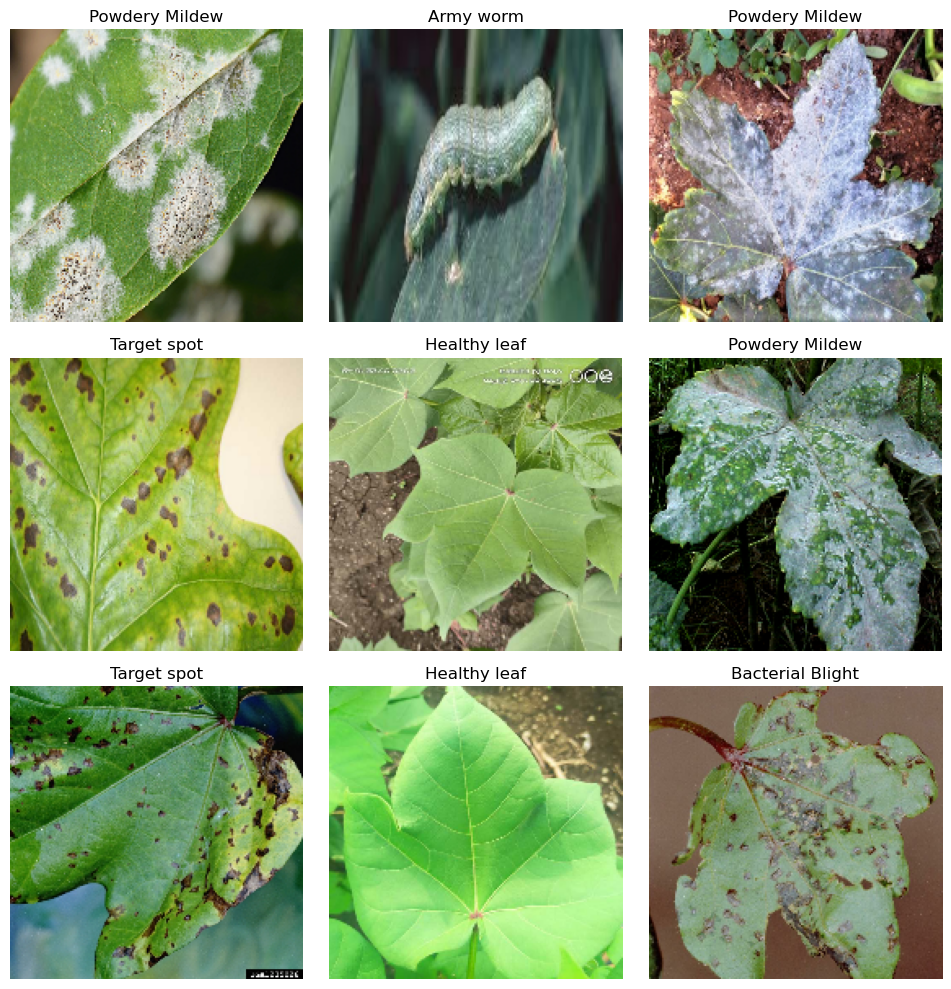

In [9]:
# Here are the first nine images from my training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        save_fig("sample_training_diseases_images")

In [10]:
# manually iterate of the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [11]:
# configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# Standardize values to be in the [0,1] RGB channel range by using tf.keras.Rescaling
normalization_layers = layers.Rescaling(1./255)

In [13]:
# Reduce overfitting through data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

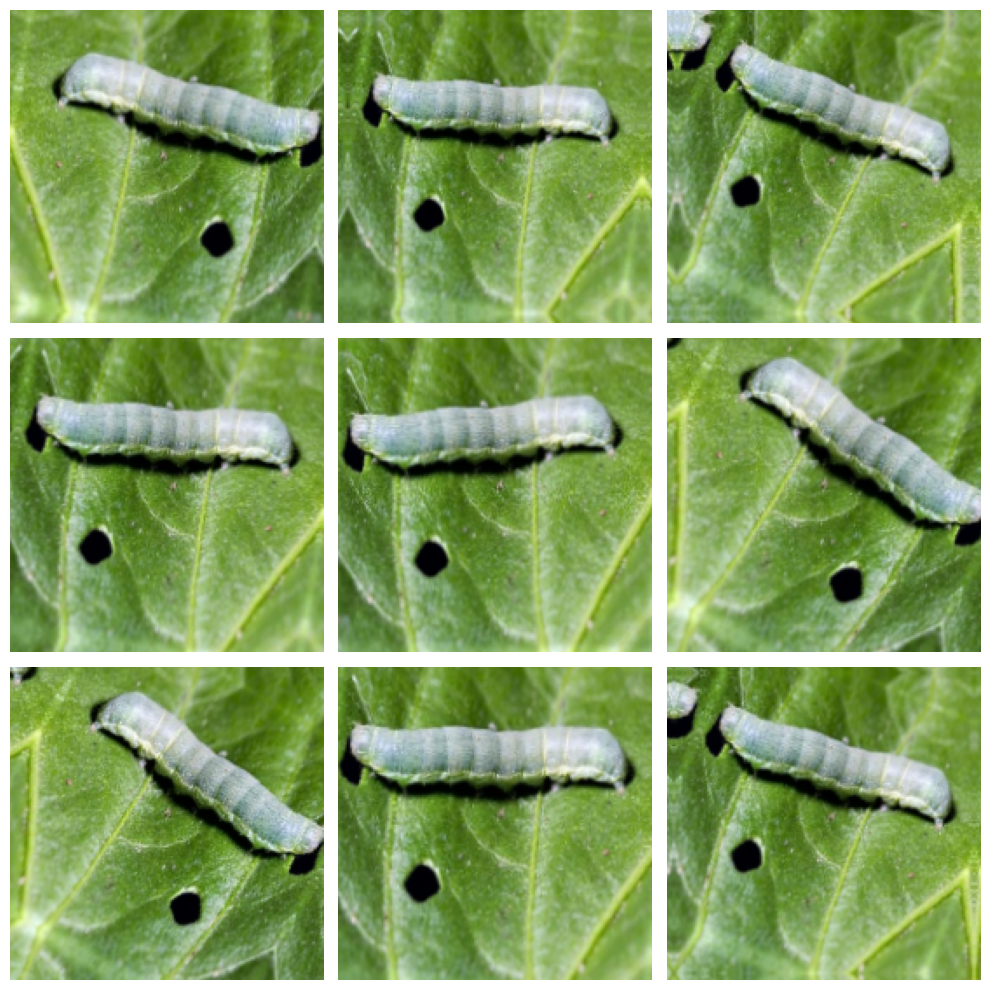

In [14]:
# visualize a few augmented examples by applying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')
        save_fig("sample_augmented_images")

In [15]:
# introduce Dropout in the network to help reduce overfitting further
num_classes = len(class_names)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])

In [16]:
# compile and train the model

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [18]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
6/6 [==============================] - 16s 2s/step - loss: 2.0150 - accuracy: 0.2053 - val_loss: 1.7846 - val_accuracy: 0.1915
Epoch 2/15
6/6 [==============================] - 8s 1s/step - loss: 1.7686 - accuracy: 0.1789 - val_loss: 1.6711 - val_accuracy: 0.3617
Epoch 3/15
6/6 [==============================] - 8s 1s/step - loss: 1.6762 - accuracy: 0.2526 - val_loss: 1.7302 - val_accuracy: 0.2766
Epoch 4/15
6/6 [==============================] - 8s 1s/step - loss: 1.6262 - accuracy: 0.3368 - val_loss: 1.4298 - val_accuracy: 0.4043
Epoch 5/15
6/6 [==============================] - 8s 1s/step - loss: 1.5047 - accuracy: 0.4211 - val_loss: 1.3713 - val_accuracy: 0.5532
Epoch 6/15
6/6 [==============================] - 8s 1s/step - loss: 1.3568 - accuracy: 0.5053 - val_loss: 1.3114 - val_accuracy: 0.5319
Epoch 7/15
6/6 [==============================] - 7s 1s/step - loss: 1.4108 - accuracy: 0.4526 - val_loss: 1.4180 - val_accuracy: 0.4468
Epoch 8/15
6/6 [========================

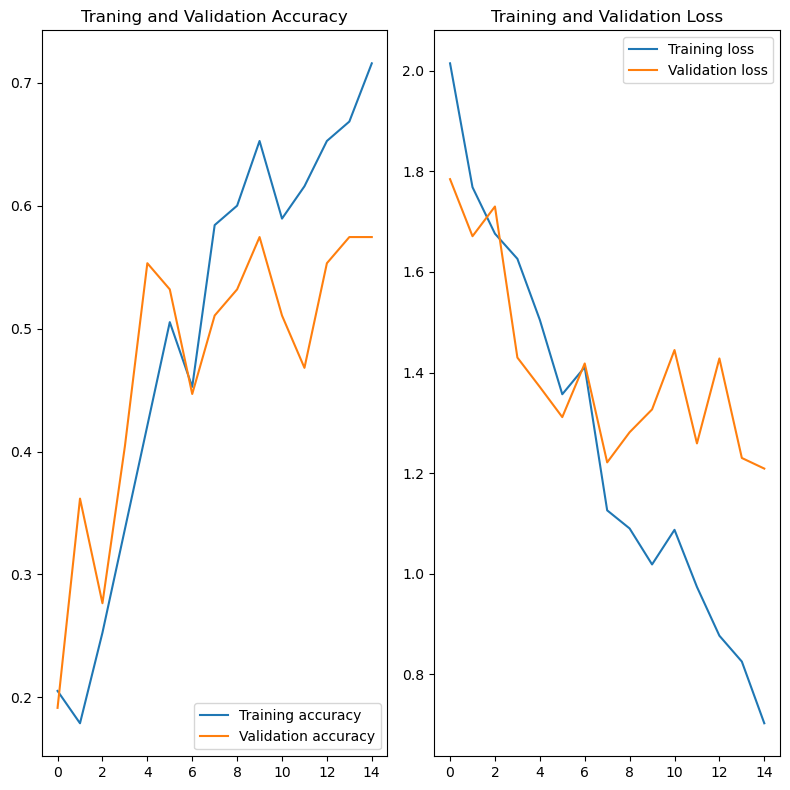

In [19]:
# Visualizing the training results

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Traning and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
save_fig("training_and_validation_accuracy_and_loss_2")
plt.show()

In [26]:
# predict on new data
img = tf.keras.utils.load_img(
    "cotton-plant-disease-data/test_1.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100* np.max(score))
)

1/1 [==============================] - 0s 50ms/step
This image most likely belongs to Powdery Mildew with a 97.68 percent confidence.


In [27]:
# convert the model to tensorflow lite

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save the model

with open('cotton_plant_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ojare\AppData\Local\Temp\tmponerb9uo\assets


INFO:tensorflow:Assets written to: C:\Users\ojare\AppData\Local\Temp\tmponerb9uo\assets


In [28]:
# run the tensorflow lite model
TF_MODEL_FILE_PATH = 'cotton_plant_disease_model.tflite'
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [29]:
# print the signatures of the converted model to get the names of the inputs and outputs

interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_input'], 'outputs': ['outputs']}}

In [30]:
# test the loaded model

classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [31]:
# make predictions using tensorflow lite model

predictions_lite = classify_lite(sequential_input = img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [32]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)],  100 * np.max(score_lite))
)

This image most likely belongs to Powdery Mildew with a 97.68 percent confidence.


In [33]:
print(np.max(np.abs(predictions - predictions_lite)))

4.4852495e-06


In [34]:
import os
import json
import tempfile
import requests

In [35]:
MODEL_DIR = 'ML/models/cotton_plant_disease_model'
version = '1'
export_path = os.path.join(MODEL_DIR, str(version))

# save the model
model.save(export_path, save_format='tf')
print('\nexport_path = {}'.format(export_path))
!dir {export_path}

INFO:tensorflow:Assets written to: ML/models/cotton_plant_disease_model\1\assets


INFO:tensorflow:Assets written to: ML/models/cotton_plant_disease_model\1\assets



export_path = ML/models/cotton_plant_disease_model\1


Invalid switch - "models".


In [36]:
model.save("cotton_plant_disease_classifier.h5")